# A4 Feature Engineering [𐄡]

#### Welcome to A4! 

Please enter answers to the questions in the specified Markdown cells below, and complete the code snippets in the associated python files as specified. When you are done with the assignment, follow the instructions at the end of this assignment to submit.

### Learning Objective 🌱
In this assignment, you will gain experience transforming clinical data into sets of features for downstream statistical analysis, utilizing the cohort that you developed in A3. In particular, you will extract features from vitals, diagnosis codes, and more that can be used to predict the future development of septic shock. You will practice using common time-saving tools in the **Pandas 🐼** library and **Python 🐍** programming language that are ideally suited to these tasks.

### Resources 📖
- Pandas Cheat Sheet 🐼: [https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

- Relevant publications:

  - You will not be replicating the models presented in ["A targeted real-time early warning score (TREWScore) for septic shock" by Henry et al.](http://stm.sciencemag.org/content/7/299/299ra122.full) directly, but we include a link to the paper for your reference.



### Environment Set-Up 🐍
To begin, we will need to set up an virtual environment with the necessary packages. A virtual environment is a self-contained directory that contains a Python interpreter (aka Python installation) and any additional packages/modules that are required for a specific project. It allows you to isolate your project's dependencies from other projects that may have different versions or requirements of the same packages.

In this course, we require that you utilize [Miniconda](https://docs.conda.io/en/latest/miniconda.html) to manage your virtual environments. Miniconda is a lightweight version of [Anaconda](https://www.anaconda.com/), a popular Python distribution that comes with many of the packages that are commonly used in data science.

#### Instructions for setting up your environment using Miniconda:
1. If you do not already have Miniconda installed, download and install the latest version for your opperating system from the following link: [https://docs.conda.io/en/latest/miniconda.html#latest-miniconda-installer-links](https://docs.conda.io/en/latest/miniconda.html#latest-miniconda-installer-links)

2. Create a new virtual environment for this assignment by running the following command in your terminal:

   ```bash
   conda env create -f environment.yml
   ```

   This will create a new virtual environment called `biomedin215`

3. Activate your new virtual environment by running the following command in your terminal:

   ```bash
   conda activate biomedin215
   ```

   This will activate the virtual environment you created in the previous step.

4. Finally, ensure that your `ipynb` (this notebook)'s kernel is set to utilize
the `biomedin215` virtual environment you created in the previous steps. Depending on
which IDE you are using to run this notebook, the steps to do this may vary.


In [1]:
from time import process_time
# Run this cell: 
# The lines below will instruct jupyter to reload imported modules before 
# executing code cells. This enables you to quickly iterate and test revisions
# to your code without having to restart the kernel and reload all of your 
# modules each time you make a code change in a separate python file.

%load_ext autoreload
%autoreload 2

In [2]:
# Run this cell to ensure the environment is setup properly
# If you get an error, please ensure that the environment was activated for this notebook
# Note: You do not need to edit this cell
import pandas as pd
import os
import warnings

print("Imports Successful!")

Imports Successful!


### *Note to Students:* 📚

>Throughout the assignment, we have provided `sanity checks`: small warnings that will alert you when your implementation is different from the solution. Our goal in providing these numbers is to help you find bugs or errors in your code that may otherwise have gone unnoticed. Please note: the sanity checks are just tools we provided to be helpful, and should not be treated as a target to hit. We manually grade each assignment based on the code you submit, and not based on whether you get the exact same numbers as the sanity checks.

Even if you are failing the sanity checks, if your implementation is correct with minor errors, you will still receive the majority of the points (if not all).

In [3]:
# Run this cell to set up sanity checks warnings
# Note: You do not need to change anything in this cell

# Creates a custom warning class for sanity checks
class SanityCheck(Warning):
    pass

# Sets up a cosutom warning formatter
def custom_format_warning(message, category, filename, lineno, line=None):
    if category == SanityCheck:
        # Creates a custom warning with orange text
        return f'\033[38;5;208mSanity Check - Difference Flagged:\n{message}\033[0m\n'
    
    return '{}:{}: {}: {}\n'.format(filename, lineno, category.__name__, message)

# Sets the warning formatter for the entire notebook
warnings.formatwarning = custom_format_warning

### Data Description 📂

We will be utilizing the same subset of the [MIMIC III database](https://mimic.mit.edu/docs/iii/about/) we utilized in A3: the 1,000 subject development cohort you created previously. You will start with a dataset very similar to what you may have generated at the end of the prior assignment.

You will analyze the available data to identify a cohort of patients that underwent septic shock during their admission to the ICU. **All of the data you need for this assignment is available on Canvas.** 

Once you have downloaded and unzipped the data, you should see the following `7` csv files:
- `cohort_labels.csv`

- `ADMISSIONS.csv`

- `DIAGNOSES_ICD.csv`

- `notes_small_cohort_v2.csv`

- `snomed_ct_isaclosure.csv`

- `snomed_ct_str_cui.csv`

- `vitals_small_cohort.csv`

**Specify the location of the folder containing the data in the following cells:**

In [4]:
# Specify the path to the folder containing the data files
data_dir = "/Users/stevenang/Documents/stanford/biomedin215/assignments/A4/data" # <-- TODO: You will need to change this path

In [5]:
# Run this cell to make sure all of the files are in the specified folder
expected_file_list = ["cohort_labels.csv", "ADMISSIONS.csv", "DIAGNOSES_ICD.csv", "notes_small_cohort_v2.csv", "snomed_ct_isaclosure.csv", "snomed_ct_str_cui.csv","vitals_small_cohort.csv"]

for file in expected_file_list:
    assert os.path.exists(os.path.join(data_dir, file)), "Can't find file {}".format(file)

print("All files successfully found")

All files successfully found


# 1. Defining labels for prediction 🟩🟩🟩🟥🟩🟩🟥🟩

## `1.1`: (`10 pts`)

Utilizing our version of the 1,000 subject development cohort you created in the previous assignment, in this assignment, your task is to engineer a set of features that will be used as the inputs to a model that will predict:

```
At 12 hours into an admission, whether septic shock will occur during the remainder of the admission, with at least 3 hours of lead time (the amount of time between when an event is predicted to occur and when it actually occurs).
```

To begin, let's load in our intial dataframes. 
- `cohort_labels.csv`: contains the cohort with the various labels we defined in A3. (This dataset will probably look very similar to the dataset you had at the end of A3.)

- `ADMISSIONS.csv`: an extract of the ADMISSIONS table from MIMIC-III. This contains information about patient admission events to the hospital.

In [6]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to change anything in this cell

# Reads in the tables from the CSV files
cohort_labels = pd.read_csv(os.path.join(data_dir, "cohort_labels.csv"))
admissions = pd.read_csv(os.path.join(data_dir, "ADMISSIONS.csv"))

# Sets the column names to be lowercase
admissions.columns = [x.lower() for x in admissions.columns]

In [7]:
# Run this cell to view what the first few rows of the cohort_labels table look like
# Note: You do not need to change anything in this cell
cohort_labels.head(3)


,subject_id,hadm_id,icustay_id,charttime,sepsis,severe_sepsis,septic_shock
0,3,145834,211552.0,2101-10-20T16:40:00Z,False,False,False
1,3,145834,211552.0,2101-10-20T16:49:00Z,False,False,False
2,3,145834,211552.0,2101-10-20T19:12:00Z,False,False,False


In [8]:
# Run this cell to view what the first few rows of the admissions table look like
admissions.head(3)

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1


In [9]:
# (OPTIONAL TODO:) It is always a good idea to filter out columns that you don't need from DataFrames.
# As always, feel free to add code to your notebooks to do this. This is not required for the assignment.
# You may want to come back to this later when you are more familiar with the data and know which columns you need.

admissions.drop(['deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'hospital_expire_flag' ], axis=1, inplace=True)

First, we need to do some preprocessing. When working with dates in Pandas, it is always a good idea to convert the data to a datetime format. This can help improve performance, memory efficiency, and also allow us to use the many built-in features of Pandas that are only available for datetime objects. Implement the function `preprocess_dates` in the file `src/utils.py` following the instructions in the docstring, to convert specific columns in the input dataframe that contain dates to datetime objects.

In [10]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.utils import preprocess_dates

preprocess_dates(admissions, ["admittime", "dischtime"], ["%Y-%m-%d %H:%M:%S"]*2, inplace=True)
preprocess_dates(cohort_labels, ["charttime"], ["%Y-%m-%dT%H:%M:%SZ"],inplace=True)

#==============
# Sanity Checks
if not "datetime" in str(admissions["admittime"].dtype).lower():
    warnings.warn("The admittime column is not a datetime object", SanityCheck)

if not admissions["admittime"].dt.tz is not None:
    warnings.warn("The admittime column is not in UTC", SanityCheck)

Next, we will derive the **labels** and **index times** in a way that aligns with the task description above. Note that we are no longer following the same procedure as the TREWScore paper.

We will use the following definitions:

* We will only assign labels to admissions of at least twelve hours in duration.

* An admission is assigned a negative label if septic shock does not occur at any time during the admission.

* An admission is assigned a positive label if septic shock occurs fifteen hours after admission or later.

* Admissions where the earliest time of septic shock occurs prior to fifteen hours after admission are removed from the study.

* For admissions that have valid labels, we assign an index time at twelve hours into the admission. For prediction, we only use information that occurs before the index time.

* In the case that a patient has multiple admissions for which a valid index time and label may be assigned, we only use the latest one.

We will use the above definitions to derive the binary classification labels for septic shock and the corresponding index times for each patient in the dataframe. Our goal is to end up with a dataframe that contains a row for each patient in `cohort_labels` that passed the inclusion criteria, with the following columns:
- `subject_id`: the unique identifier for each patient
- `hadm_id`: the unique identifier for the admission
- `label`: the binary classification label for septic shock
- `index_time`: the index time for the patient (+12 hours from admission start time)

As mentioned above, we do not want to assign labels to admissions that are less than twelve hours in duration. Implement the function `filter_admissions` in `src/labels.py` following the instructions in the docstring and run the following cell.

In [11]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.labels import filter_admissions

filtered_admissions = filter_admissions(admissions)

#==============
# Sanity Checks

# Check that the number of rows is correct
if filtered_admissions.shape[0] != 57925:
    warnings.warn("Number of rows is different than expected", SanityCheck)

Our next step will be to merge the two dataframes together, and create two additional columns:
- `relative_charttime`: The amount of time between the charttime and the start of the admission
- `index_time`: The time at which a prediction will be made (12 hours after the start of the admission)

Implement the functions `merge_and_create_times`, `get_relative_charttime`, and `get_index_time` in `src/labels.py` following the instructions in the appropriate docstrings. When you are done, run the cell below to sanity check your implementation.

In [12]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.labels import merge_and_create_times

merged_cohort = merge_and_create_times(cohort_labels,filtered_admissions)

#==============
# Sanity Checks
if merged_cohort.shape[0] != 247610:
    warnings.warn(f"Number of rows is different than expected: shape[0] = {merged_cohort.shape[0]}", SanityCheck)

Now we need to use this merged dataframe to create a new dataframe that contains the labels utilizing the definitions above. Implement the function `get_shock_labels` in `A4/labels.py` following the instructions in the docstring to create a new dataframe with a binary septic shock label for each patient.

In [13]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.labels import get_shock_labels

shock_labels = get_shock_labels(merged_cohort)


#==============
# Sanity Check:
for col in shock_labels.columns:
    if col not in ["subject_id", "hadm_id", "admittime", "dischtime", "index_time", "label", "icustay_id"]:
        warnings.warn(f"Expected column {col} not found", SanityCheck)
    
if len(shock_labels) != 974:
    warnings.warn(f"Expected length different: length = {len(shock_labels)}", SanityCheck)

if len(shock_labels) != shock_labels["subject_id"].nunique():
    warnings.warn(f"Expected no duplicate rows", SanityCheck)

In [14]:
# Run this cell to see the class balance of the labels:
# Note: you do not need to modify the code in this cell
shock_labels["label"].value_counts()

label
False    905
True      69
Name: count, dtype: int64

# 2 Feature engineering [𐄡]

Now that we have derived labels and index times for each patient in our cohort, we can start to engineer some features from the data that occur prior to the index times and will be useful for predicting onset of septic shock.

First lets deal with diagnoses. Load in the `DIAGNOSES_ICD.csv` file by running the cell below.

In [15]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in the table from the CSV file
diagnoses = pd.read_csv(os.path.join(data_dir, "DIAGNOSES_ICD.csv"))
# Sets diagnoses's column names to lower case
diagnoses.columns = [x.lower() for x in diagnoses.columns]

## `2.1`: (`2 pts`)

Review the documentation for MIMIC to answer the following question.

**Which column from which table in MIMIC should you use to find the time of each diagnosis? Justify your response.**

 <span style="color:blue;"> According to MIMIC-III Documentation (https://mimic.mit.edu/docs/iii/tables/admissions/), the final diagnoses for a patient's hospital stay are coded on discharge and can be found on DIAGNOSES_ICD table. This means the column DISCHTIME from ADMISSION table can be used to determine time of diagnosis </span>

## `2.2`: (`3 pts`)

Utilizing the column you selected in the previous question, implement the function `get_diagnoses` in `A4/features.py` following the instructions in the docstring. When you have completed your implementation, run the cell below to sanity check.

In [17]:
from src.features import get_diagnoses

dx_features = get_diagnoses(admissions, diagnoses, shock_labels)

#============
# Sanity Check
if dx_features.shape[0] != 4031:
    warnings.warn(f"Expected length different: shape[0] = {dx_features.shape[0]}", SanityCheck)

**How many subjects have diagnoses recorded prior to the index_time? Does the resulting number make sense?**


In [18]:
# TODO: Add code to this cell to answer the above question if needed
dx_features['subject_id'].unique().shape[0]

210

 <span style="color:blue;"> We found 210 unique subjects have diagnosis prior to index_time. This makes sense as that means 210 patients have had a diagnosis made within 12 hours in one of his/her admissions. This is expected to be larger than the number of patients with True shock_label from part 1, since that only accounts for the lastest admission to label the patients. </span>

## `2.3`: (`4 pts`)

Implement code in the following cell to answer the question

**What are the top 10 most common diagnosis codes (by number of unique patients who had the code in their history) in the data frame resulting from question 2.2? Look up the top 3 codes online and report what they refer to.**

In [19]:
# TODO: IMPLEMENT CODE HERE TO ANSWER THIS QUESTION
# Get the list of unique subject_ids based on the icd9_code
unique_subject_ids = dx_features.groupby(by='icd9_code', as_index=False)['subject_id'].unique()
# Count how many distinct subject_id we have for each icd9_code
unique_subject_ids['count'] = [len(x) for x in unique_subject_ids['subject_id']]
# Sorted by count first then icd9_code
unique_subject_ids.sort_values(by=['count', 'icd9_code'], ascending=[False, True], inplace=True)
# Print out the first 10 items with the highest count
unique_subject_ids.sort_values('count', ascending=False)[:10].icd9_code.values

array(['4019', '4280', '41401', '5849', '42731', '2859', '5990', '25000',
       '51881', '486'], dtype=object)

## `2.4`: (`4 pts`)

In this step we will create a histogram for the set of codes and patients that remain after the index time filtering step. 

Implement the function `show_diagnosis_hist` in `visualize.py` following the instructions in the docstring. When you are done, run the cell below to show the histogram.

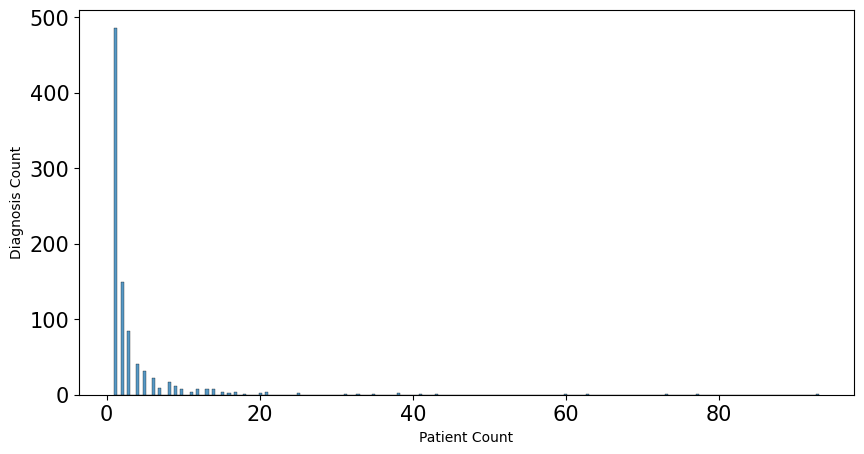

In [20]:
from src.visualize import show_diagnosis_hist

# Create the plot
show_diagnosis_hist(dx_features, "diagnosis_count_hist.png")

**In 1-2 sentences, interpret the resulting histogram.**

 <span style="color:blue;"> YOUR ANSWER HERE </span>

## `2.5`: (`5 pts`)

From the histogram you generated earlier, it's evident that there's a substantial variation in the frequency of different diagnoses. Specifically, a significant number of diagnoses appear very infrequently in the dataset.

Such a distribution is characteristic of a `sparse feature space`. Here is what that means:

`Sparse Feature Space`: In the context of data with categorical variables, a sparse feature space refers to the scenario where many possible features (in this case, diagnosis codes) appear infrequently, resulting in a 'wide form' matrix with many zeros or absent values.

This can have problematic implications for downstream analyses:
- First, sparse features can pose **computational challenges**: Many machine learning algorithms struggle with high dimensionality and sparsity. They can become computationally intensive or may not work optimally.
- Second, sparse features can lead to **issues with generalization**: Rare features often don't contribute significantly to model training. In some cases, they might even introduce noise, making the model overfit to a training set and perform poorly on new, unseen data.





Given these challenges, it's beneficial to address sparsity. One strategy to manage this involves quantifying the "usefulness" or "specificity" of each feature, and utilizing this information to select features or even perform feature aggregation (grouping features to capture broader patterns). This is where `Information Content (IC)` comes into play:

**Definition**: `IC` is a metric that provides a measure of the specificity or the informativeness of a feature based on its frequency of occurrence. Features that are very common have a higher probability and thus a lower IC, while rare features have a lower probability, resulting in a high IC value.

The IC of a feature that occurs in a set of records is calculated as follows:

$IC\left(\text{featureA}\right) = -log_2 \left( \frac{count(\text{Patients with featureA})}{count(\text{All Patients})} \right)$

Implement the function `calc_ic` in `src/features.py` to calculate the IC of each diagnosis code in the dx_features dataframe using the equation above and following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [21]:
from src.features import calc_ic

icd9_ic = calc_ic(dx_features, all_patients_count=len(shock_labels))

if icd9_ic.shape[0] != 914:
    warnings.warn(f"Expected number of rows different: shape[0] = {icd9_ic.shape[0]}", SanityCheck)

## `2.6` (`3 pts`)

Use the code cell below to answer the following question:

**What is the range (min and max) of ICs observed in your data? What are the 10 most specific ICD9 codes?**



In [22]:
                # TODO: IMPLEMENT CODE HERE TO ANSWER THE QUESTION
print(f"Max of ICs observed: {icd9_ic['icd9_code_ic'].max()}")
print(f"Min of ICs observed: {icd9_ic['icd9_code_ic'].min()}")
print(f"Top 10 icd_9 codes: {icd9_ic.sort_values('icd9_code_ic', ascending=False)[:10]}")


Max of ICs observed: 9.927777962082342
Min of ICs observed: 3.3886191509743107
Top 10 icd_9 codes:      icd9_code  icd9_code_ic
3294     V1007      9.927778
3621      4580      9.927778
3584      4263      9.927778
3585      7210      9.927778
3609     37852      9.927778
3613      5307      9.927778
3614      9828      9.927778
3615     E9509      9.927778
3616      5680      9.927778
3619     29620      9.927778


 <span style="color:blue;"> The range of IC is 3.3886191509743107 (min) to 9.927777962082342 (max). </span><p>
 <span style="color:blue;">According to the definition, the feature with higher specificity or the informativeness are rare and have high IC, hence top 10 codes are: 'V1007', '4580', '4263', '7210', '37852', '5307', '9828', 'E9509', '5680', '29620'</span>

## `2.7` (`2 pts`)

Now it's time to perform some feature selection. Implement the function `filter_ic` in `src/features.py` to filter the dataframe to only include the diagnoses with an IC between 4 and 9 (inclusive) following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [23]:
from src.features import filter_ic

dx_selected = filter_ic(dx_features, icd9_ic)


#============
# Sanity Check
if dx_selected.shape[0] != 3044:
    warnings.warn(f"Expected number of rows different: shape[0] = {dx_selected.shape[0]}", SanityCheck)

## `2.8` (`12 pts`)

Now we have our diagnosis features and the times they occurred for each patient. The next step is to create a patient-feature matrix that summarizes and organizes these diagnosis features. In this matrix, each row should represent a patient and each column should represent a diagnosis code, time-binned by whether or not it occurred in the 6 months prior to the index time.

Put simply, for each diagnosis code, we want to generate two features:

- One feature representing the count of the number of times the code was observed in the six months prior to the index time.
- Another feature for the number of times that code appeared more than six months before the index time.

Note that the ICU stay is the first time many patients have been seen at this hospital, so patients may have few or no prior recorded diagnoses.


Implement the function `get_diagnoses_features` in `src/features.py` to create the patient-feature matrix following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [24]:
from src.features import get_diagnosis_features

diagnosis_features = get_diagnosis_features(dx_selected)

#============
# Sanity Check

if diagnosis_features.shape[0] != 209:
    warnings.warn(f"Expected number of rows different: shape[0] = {diagnosis_features.shape[0]}", SanityCheck)

## `2.9` (`4 pts`)

Now let's add features from notes. To do so, we'll have to process some text.

The `noteevents` table in MIMIC is large and unwieldy, so we've extracted the rows from that table that you will need. The result is in the file `notes_small_cohort_v2.csv`. Let's load this in now.

In [25]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in the table from the CSV file
notes = pd.read_csv(os.path.join(data_dir, "notes_small_cohort_v2.csv"))

# Set notes' column names to lower case
notes.columns = [x.lower() for x in notes.columns]

# Utilizes the preprocess_dates function to convert the dates to datetime objects
preprocess_dates(notes, ["chartdate"], ["%Y-%m-%d"], inplace=True)


In [26]:
# Let's check out what the notes data looks like
notes.head(3)

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,note_text
0,44005,3,145834,2101-10-31 00:00:00+00:00,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...
1,94503,3,145834,2101-10-21 00:00:00+00:00,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: S/P Car...
2,94502,3,145834,2101-10-21 00:00:00+00:00,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Left ve...


In the MIMIC database, notes are primarily timestamped using the chartdate column, which captures the date (but not the precise time) when the note was recorded. Another column, charttime, exists, but it is predominantly empty or null for most entries. This presents a challenge when we wish to filter notes based on precise times, such as a patient-specific cutoff time.

To address this, our approach will be to filter notes by ensuring that they were recorded strictly before the day corresponding to each patient's `index_time`. This means that if a note's chartdate is the same as the `index_time` (*even if charttime were available*), we would exclude it because we can't ascertain if it was before or after the exact `index_time` time on that day.

Implement the function `filter_by_chartdate` in `src/notes.py` to filter the notes dataframe to only include notes in a patient's record that were recorded before the day corresponding to each patient's `index_time`, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [28]:
from src.notes import filter_by_chartdate

notes_filtered = filter_by_chartdate(shock_labels, notes)

#============
# Sanity Check
if notes_filtered.shape[0] != 13213:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {notes_filtered.shape[0]}", SanityCheck)

## `2.10` (`2 pts`)

The Unified Medical Language System (UMLS) is a multi-dimensional and dynamic compendium developed by the U.S. National Library of Medicine (NLM) to bridge the gap between various healthcare terminologies and classification systems. At the heart of UMLS lie various terminologies, which provide concept hierarchies as well as sets of terms for individual concepts. For example, there are more than 50 terms in UMLS terminologies for the concept `myocardial infarction`!

Here we will use the SNOMED CT (Systematized Nomenclature of Medicine - Clinical Terms): A comprehensive clinical terminology encompassing diseases, clinical findings, procedures, etc. SNOMED CT is a multi-hierarchy system, meaning that each concept can have multiple parents. For example, the concept `myocardial infarction` has two parents: `acute coronary syndrome` and `myocardial disorder`.

In this assignment, you will use the SNOMED CT hierarchy and UMLS term sets to construct a dictionary of terms for inflammatory disorders, which you will use to search for associated terms in MIMIC III notes to create additional features.

First, load `snomed_ct_isaclosure.csv` and `snomed_ct_str_cui.csv` by running the code in the following cell:

In [29]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in tables from the CSV files
snomed_ct_isaclosure = pd.read_csv(os.path.join(data_dir, "snomed_ct_isaclosure.csv"))
snomed_ct_str_cui = pd.read_csv(os.path.join(data_dir, "snomed_ct_str_cui.csv"))

In [30]:
# snomed_ct_isaclosure contains the child-parent CUI relationships for all of SNOMED CT.
# Note: You do not need to modify the code in this cell
snomed_ct_isaclosure.head(3)

,descendant,ancestor,dist
0,C0038891,C0038891,0
1,C0038891,C0220806,3
2,C0038891,C0033684,2


In [31]:
# snomed_ct_str_cui contains the terms (each with a unique term identifier, tid) for each SNOMED CT CUI
# Note: You do not need to modify the code in this cell
snomed_ct_str_cui.head(3)

,tid,str,CUI
0,1,and,C1706368
1,2,0,C0919414
2,3,of,C0332285


Implement the function `merge_snomed` in `src/notes.py` to merge the two dataframes together, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [32]:
from src.notes import merge_snomed

# Merge the two tables
snomed_ct_concept_str = merge_snomed(snomed_ct_isaclosure, snomed_ct_str_cui)

#============
# Sanity Check
if snomed_ct_concept_str.shape[0] != 16407662:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {snomed_ct_concept_str.shape[0]}", SanityCheck)

if snomed_ct_concept_str.shape[1] != 2:
    warnings.warn(f"Number of columns differs from expected: shape[1] = {snomed_ct_concept_str.shape[1]}", SanityCheck)

## `2.11` (`6 pts`)

One feature that is very likely to impact the likelihood of a patient to develop septic shock is whether they currently have or have a history of inflammatory disorders. Let's extract information from clinical notes to look for the presence of this class of disease.

To accomplish this,  implement the function `get_cui_list` in `src/notes.py` to get a list of all the terms that correspond to a CUI in the `snomed_ct_isaclosure` dataframe and that have a specified number of characters or fewer, following the instructions in the docstring. Then, use this function to get a set of terms for `inflammatory disorders` (`C1290884`) that have 20 characters or fewer. How many terms are in the dictionary?

In [33]:
from src.notes import get_cui_list

inflammatory_disorder_list = get_cui_list(snomed_ct_concept_str, "C1290884", 20)

#============
# Sanity Check

if len(inflammatory_disorder_list) != 2991:
    warnings.warn(f"Length of inflammatory_disorder_list differs from expected: length = {len(inflammatory_disorder_list)}", SanityCheck)

if "ekc" != inflammatory_disorder_list[0]:
    warnings.warn(f"First element of inflammatory_disorder_list differs from expected: element = {inflammatory_disorder_list[0]}", SanityCheck)

## `2.12` (`7 pts`)

Now let's determine if the notes contain these terms. Implement the function `extract_terms` in `src/notes.py` to search the note text for the terms you collected in the previous step, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [36]:
from src.notes import extract_terms

term_df = extract_terms(notes_filtered, inflammatory_disorder_list, 50)

#============
# Sanity Check
if term_df.shape[0] != 13213:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {term_df.shape[0]}", SanityCheck)


## `2.13` (`6 pts`)

Now that we have extracted the terms from the notes and have a representation of which term is in which note in a `wide` dataframe format, we want to determine which concepts are present in each note. To do this, we will reshape the dataframe to a `long` format and normalize terms back to their corresponding concepts. 

Implement the function `normalize_terms` in `src/notes.py` following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [39]:
    from src.notes import normalize_terms

concept_df = normalize_terms(term_df, snomed_ct_concept_str)

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,...,arc eye,cecitis,chagoma,colitis,coxitis,ecthyma,empyema,gangosa,ileitis,mucitis
2,128008,4,185777,2191-03-15 00:00:00+00:00,NaN,NaN,ECG,Report,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
7,818477,4,185777,2191-03-15 00:00:00+00:00,2191-03-15 19:55:00,NaN,Radiology,LIVER OR GALLBLADDER US (SINGLE ORGAN),NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
8,818466,4,185777,2191-03-15 00:00:00+00:00,2191-03-15 16:20:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
37,194035,9,150750,2149-11-09 00:00:00+00:00,NaN,NaN,ECG,Report,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
42,806867,9,150750,2149-11-09 00:00:00+00:00,2149-11-09 11:50:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38022,1280261,1386,147056,2155-09-15 00:00:00+00:00,2155-09-15 04:36:00,2155-09-15 04:48:00,Nursing/other,Report,19596.0,NaN,...,0,0,0,0,0,0,0,0,0,0
38052,879032,1386,147056,2155-09-14 00:00:00+00:00,2155-09-14 14:57:00,NaN,Radiology,ABDOMEN U.S. (COMPLETE STUDY),NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
38060,878969,1386,147056,2155-09-14 00:00:00+00:00,2155-09-14 03:51:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
38177,1280409,1390,196622,2123-06-21 00:00:00+00:00,2123-06-21 18:28:00,2123-06-21 18:41:00,Nursing/other,Report,19150.0,NaN,...,0,0,0,0,0,0,0,0,0,0


,CUI,term
0,C0038891,surfactant
1,C0038891,surfactant (substance)
2,C0220806,surfactant
3,C0220806,surfactant (substance)
4,C0033684,surfactant
...,...,...
16407657,C1629038,topical sulphur
16407658,C1629038,topical sulfur (substance)
16407659,C3217334,topical sulfur
16407660,C3217334,topical sulphur


,subject_id,chartdate,variable,value
12288,1313,2166-07-25 00:00:00+00:00,ekc,1
25242,1257,2195-01-13 00:00:00+00:00,ipv,1
26447,17,2134-12-29 00:00:00+00:00,mma,1
26461,21,2134-09-12 00:00:00+00:00,mma,1
26463,21,2134-09-14 00:00:00+00:00,mma,1
...,...,...,...,...
617820,984,2143-01-09 00:00:00+00:00,empyema,1
617824,984,2143-01-22 00:00:00+00:00,empyema,1
618146,1006,2159-05-28 00:00:00+00:00,empyema,1
618160,1006,2159-07-22 00:00:00+00:00,empyema,1


## `2.14` (`7 pts`)

As with the diagnoses, we must transform these concepts data into a patient-feature matrix. Transform `concept_df` into a patient-feature matrix where each row is a patient and each column is the presence or absence of a concept. Here we are not going to do any time binning. Each concept should have only one column. Instead of counts, use a binary indicator to indicate that the concept was present in the patient's notes.

Implement the function `get_note_concept_features` in `src/notes.py` following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [88]:
from src.notes import get_note_concept_features

note_concept_features = get_note_concept_features(concept_df)

## `2.15` (`2 pts`)

Now let's engineer some features from vital sign measurements also relevant to predicting septic shock! Load in the `vitals_small_cohort.csv` file by running the cell below.

In [35]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in the table from the CSV file
vitals = pd.read_csv(os.path.join(data_dir, "vitals_small_cohort.csv"))

# Preprocess the dates
preprocess_dates(vitals, ["charttime"], ["%Y-%m-%dT%H:%M:%SZ"], inplace=True)


Let's filter the vitals so we are only looking at Heart Rate measurements that were taken prior to the patient's index time.

Implement the function `filter_vitals` in `src/vitals.py` to filter the vitals dataframe to only include measurements that were taken prior to the patient's index time, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [36]:
from src.vitals import filter_vitals

vitals_filtered_hr = filter_vitals(vitals, shock_labels, ["HeartRate"])

# ============
# Sanity Check
if vitals_filtered_hr.shape[0] != 9328:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {vitals_filtered_hr.shape[0]}", SanityCheck)

## `2.16` (`4 pts`)

Now lets construct some features. One feature of interest might be the latest value of the heart rate before the `index_time`. 

Implement the function `get_latest_hr` in `src/vitals.py` to get the latest heart rate measurement before the `index_time` for each patient. When you are done, run the cell below to sanity check your implementation.

In [37]:
from src.vitals import get_latest_hr

latest_hr_df = get_latest_hr(vitals_filtered_hr)

Now, let's create a histogram to look at the distribution of the latest heart rate values.

Implement the function `show_hr_hist` in `src/visualize.py` to plot a histogram of the latest heart rate values, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

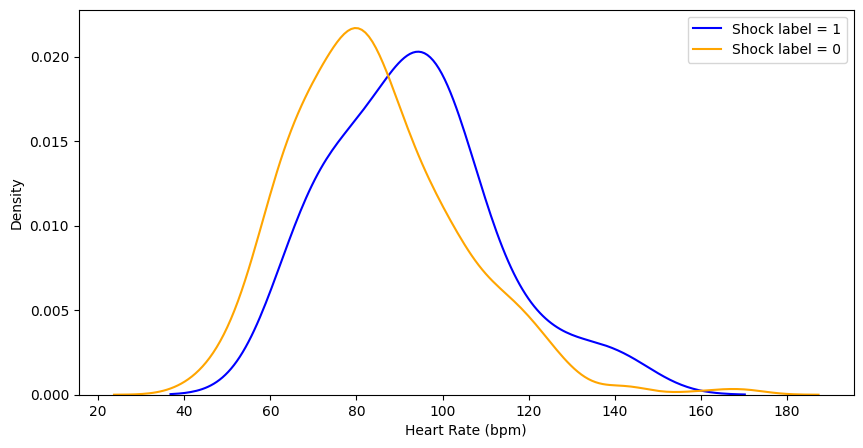

In [38]:
from src.visualize import show_hr_plot

# Create the plot
show_hr_plot(latest_hr_df, "hr_plot.png")

## `2.17` (`4 pts`)

There are some additional considerations we should think about prior to utilizing the latest heart rate feature in our model. For example, if the latest recorded heart rate is not very close to the patient's `index_time`, the feature may not be very useful for that patient. 

To examine this issue, let's plot the distribution of the time between the latest heart rate measurement and the `index_time`. Implement the function `show_hr_time_hist` in `src/visualize.py` to plot a histogram of the time between the latest heart rate measurement and the `index_time`, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

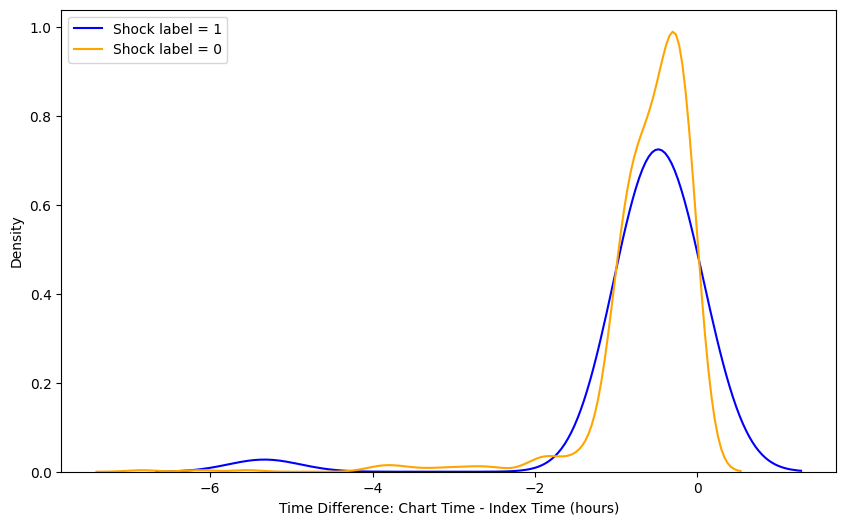

In [39]:
from src.visualize import show_hr_time_plot

# Create the plot
show_hr_time_plot(latest_hr_df, "hr_plot.png")

## `2.18` (`5 pts`)

Another concern is that when monitoring patients, especially when thinking about heart rate recordings, relying on a single data point can be misleading. By merely using the last recorded value, we run the risk of using an atypical value. Imagine a scenario where a patient's heart rate is regularly around 80 beats per minute, but due to some temporary distress or a device error, the last recorded value spikes to 120 bpm. If we base our analysis or decisions on this single data point, our conclusions will be skewed.

To address these concerns, instead of using just the last measurement, we can utilize a more robust metric: the time-weighted average heart rate. The idea behind a time-weighted average is to account for all measurements while giving more weight to recent ones. This ensures that:
- All data points contribute to the final value.
- More recent data has a higher influence on the average, as it might be more relevant to the patient's current state.

Use the formula $w = e^{(-|\Delta t| - 1)}$ to calculate the weights of each measurement, where $\Delta t$ is the time difference between the measurement time and the cutoff time in hours. 

Calculate the weighted average for each patient with the formula $\bar{x}_w = \sum(x_i w_i)/\sum(w_i)$, where $x_i$ is the value of the measurement and $w_i$ is the weight of that measurement, and $i$ ranges from 1 to the total number of measurements for that patient.

The result should be a dataframe with two columns: `subject_id` and `time_wt_avg`. Implement the function `get_time_weighted_hr` in `src/vitals.py` to calculate the time-weighted average heart rate for each patient, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [40]:
from src.vitals import get_time_weighted_hr

time_weighted_hr_df = get_time_weighted_hr(vitals_filtered_hr)

## `2.19` (`4 pts`)

Let's do a sanity check to see if what we've done makes sense. We expect that the time-weighted average heart rate and the latest recorded heart rate should be similar.

Make a scatterplot of the latest recorded heart rate (x-axis) and the time-weighted average heart rate (y-axis) of each patient. Implement the function `show_hr_scatter` in `src/visualize.py` to plot the scatterplot. When you are done, run the cell below to sanity check your implementation.

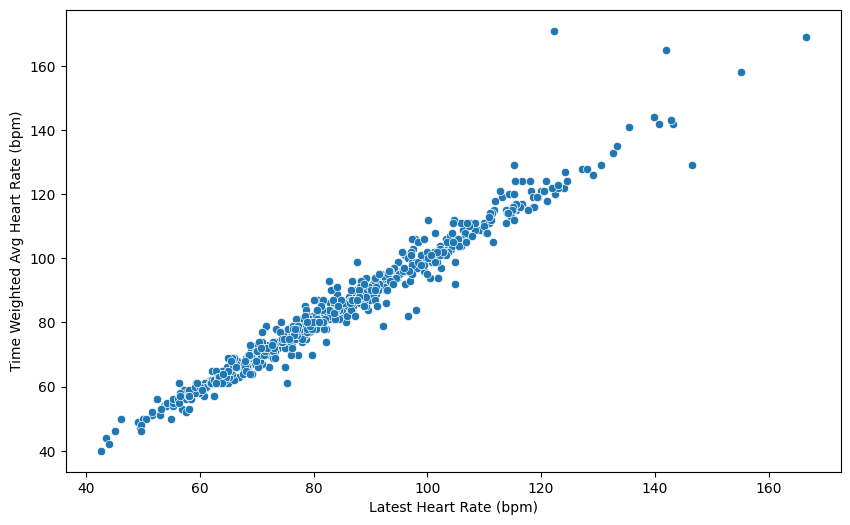

In [41]:
from src.visualize import show_hr_scatter

# Create the plot
show_hr_scatter(latest_hr_df, time_weighted_hr_df, "hr_scatter.png")

In [42]:
# Finally run this cell to get all the heart rate features together in the same dataframe
heart_rate_features = pd.merge(
        latest_hr_df.drop(columns=["charttime"]),
        time_weighted_hr_df,
        on="subject_id",
        how="inner",
    ).drop(columns=["label", "index_time"])

## `2.20` (`4 pts`)

We're almost there! Our final patient-feature matrix will simply be the amalgamation of the different feature matrices we've created. Implement `join_and_clean_data` in `src/utils.py` to combine the columns of the feature matrices from diagnoses, notes, and heart rate measurements, following the instructions in the docstring. Note that not all patients have diagnoses or note features, so this function should fill in any NA values with 0 to indicate that there were no diagnoses or notes counted. Similarily, not all subjects have heart rate measurements.  Fill NA values for these features with a simple column mean imputation. 

In [43]:
from src.utils import join_and_clean_data

joined = join_and_clean_data(diagnosis_features, note_concept_features, heart_rate_features)

#============
# Sanity Check

if joined.shape[0] != 773:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {joined.shape[0]}", SanityCheck)

if joined.isna().sum().sum() != 0:
    warnings.warn(f"Dataframe contains NaN values, which is not expected", SanityCheck)
  

Use `list(joined.columns)` to look at all the features and make sure everything makes sense.

**How many total features are there?**

In [44]:
# TODO: Add code to this cell to answer question above
len(list(joined.columns)) - 1

1169

# `3` Open Ended Feature Engineering - Do something cool! (`20 pts`)

Having made it this far, you have picked up a few generalizable techniques that can now be used to extract features from various modalities of clinical data. To test the skills you've learned thus far, you now have free rein to get creative and derive whatever additional features you would like and use them alongside the disease, text and vitals features as input to a simple classifier. To help you with your task, we provide you with CSV files for ALL of the tables in MIMIC III where each table has been filtered to contain only the records for the patients in our small cohort. These are stored in the folder `additional_data`. 



In [45]:
# Run this cell to see what data files are available
# Note: You do not need to modify the code in this cell

# Let's take a look at what files we have available
# Note: You do not need to modify the code in this cell
file_list = os.listdir(os.path.join(data_dir, "additional_data"))
file_list.sort()

print("Available files: ---")
for ind, f in enumerate(file_list):
    print(f, end=" "*10)
    if ind % 3 == 2:
        print()

Available files: ---
admissions_additional.csv          chartevents_10_additional.csv          chartevents_11_additional.csv          
chartevents_12_additional.csv          chartevents_13_additional.csv          chartevents_14_additional.csv          
chartevents_1_additional.csv          chartevents_2_additional.csv          chartevents_3_additional.csv          
chartevents_4_additional.csv          chartevents_5_additional.csv          chartevents_6_additional.csv          
chartevents_7_additional.csv          chartevents_8_additional.csv          cptevents_additional.csv          
d_cpt_additional.csv          d_icd_diagnoses_additional.csv          d_icd_procedures_additional.csv          
d_items_additional.csv          d_labitems_additional.csv          datetimeevents_additional.csv          
diagnoses_icd_additional.csv          drgcodes_additional.csv          icustays_additional.csv          
inputevents_cv_additional.csv          inputevents_mv_additional.csv          labe

We also provide you with some baseline code below that runs a logistic regression classifier with a Lasso L1 penalty and reports a cross-validation AUC-ROC. Use the code below to see the performance of the model with the features you have already engineered.

In [46]:
# Run this cell (Depending on your computer and your implementation, this cell may take a while to run)
# Note: fit_model is a provided function, you do not need to implement it
# Note: Your implementation is not expected to hit any performance targets.
# With only the features we have defined above, note the results are not be very good.
# In future assignments we will take a closer look at models!
from src.model import fit_model
fit_model(joined, shock_labels)

 20%|██        | 1/5 [00:38<02:34, 38.66s/fold]

Fold 1 ROC AUC Score: 0.5900


 40%|████      | 2/5 [01:14<01:50, 36.92s/fold]

Fold 1 ROC AUC Score: 0.5418


 60%|██████    | 3/5 [01:58<01:20, 40.08s/fold]

Fold 1 ROC AUC Score: 0.4919


 80%|████████  | 4/5 [02:31<00:37, 37.43s/fold]

Fold 1 ROC AUC Score: 0.5625


100%|██████████| 5/5 [03:13<00:00, 38.62s/fold]

Fold 1 ROC AUC Score: 0.5068
Mean ROC AUC Score: 0.5386133203812762



Use the code to do the following:
* Outside of the features we engineered previously in the assignment, derive additional features that utilize at **least five of the additional data tables**. You may use tables that we have previously worked with as a part of the assignment, but we encourage you to explore these new data sources. Caveats: definition tables (e.g. d_items) do not count towards the five and using any combination of chartevents tables counts as a single table.
* Combine your derived features into a patient-feature matrix
* Adapt the model-fitting code provided above to your new dataset below


In [47]:
# Let's load in some data
#file_name = "chartevents_7_additional.csv" # <-- TODO: Change this to any file you want to load
#additional_data = pd.read_csv(os.path.join(data_dir, "additional_data", file_name))

# TODO: Repeat the above code for other tables as needed

<span><h3>Feature set 01: Patient Age</h3></span>
* Target table: `patients_additional.csv`
* Certain populations, particularly newborns and the elderly, have weaker immune systems and are at higher risk of developing sepsis and septic shock. This feature records the patient's age at admission, which was used to determine their shock_label status. The model can potentially identify correlations between a patient's age and their likelihood of developing septic shock within the first 12 hours after admission.
* As age over 89 are shifted to 300 years prior to admission according to MIMIC-III documentation, any age above 89 are manually capped at 89. Since in Assignment 3 cohort building we only included patients with age over 15, we expect that the range of values for this feature to be 15-89.

In [48]:
# TODO: Implement your own feature engineering here
data_file = "patients_additional.csv"
patient_additional_df = pd.read_csv(os.path.join(data_dir, "additional_data", data_file))
preprocess_dates(patient_additional_df, ["dob"], ["%Y-%m-%dT%H:%M:%SZ"], inplace=True)
shock_labels = get_shock_labels(merged_cohort)

In [49]:
from dateutil.relativedelta import relativedelta

def get_feature_patient_age(patient, shock_labels):
    # Merge dataframes
    merged_df = shock_labels.merge(patient, on=["subject_id"], how="inner")
    
    # Convert to datetime
    merged_df['admittime'] = pd.to_datetime(merged_df['admittime'])
    merged_df['dob'] = pd.to_datetime(merged_df['dob'])
    
    # Calculate age using relativedelta instead of direct subtraction
    merged_df['age'] = merged_df.apply(
        lambda x: relativedelta(x['admittime'], x['dob']).years, 
        axis=1
    )
    
    # Cap age at 89
    merged_df.loc[merged_df['age'] >= 89, 'age'] = 89
    
    # Select required columns
    merged_df = merged_df[['subject_id', 'age']]
    
    return merged_df

In [50]:
# Get age feature
feature_age = get_feature_patient_age(patient_additional_df, shock_labels)
display(feature_age.head(5))

,subject_id,age
0,4,47
1,6,65
2,9,41
3,11,50
4,12,72


<span><h3>Feature set 2: Related Vitals</h3></p>
* Target table(s): `d_items_additional.csv` and `chartevents table`
* Before developing septic shock, patients often show abnormal vital signs including low systolic blood pressure, irregular body temperature, and abnormal respiratory rates. For each patient, we will analyze these vital signs by calculating both their most recent values and their time-weighted averages leading up to the index time, using the same approach we used for heart rate measurements.

In [51]:
items_file_name = "d_items_additional.csv"
d_items_additional_df = pd.read_csv(os.path.join(data_dir, "additional_data", items_file_name))

In [52]:
def filter_vitals_id(d_items_additional_df, search_string):
    d_items_additional = d_items_additional_df.copy()
    pattern = "|".join(search_string)
    d_items_additional['target'] = d_items_additional['label'].str.contains(pattern, case=False, na=False).astype(bool)
    d_items_filtered = d_items_additional[d_items_additional['target']==True]
    
    return d_items_filtered

In [53]:
search_string = ["systolic"]
filtered_items = filter_vitals_id(d_items_additional_df, search_string)
filtered_items

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid,target
295,32,6,ABP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
320,57,51,Arterial BP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
671,408,442,Manual BP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
682,419,455,NBP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
705,442,480,Orthostat BP sitting [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
707,444,482,OrthostatBP standing [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
709,446,484,Orthostatic BP lying [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
715,452,492,PAP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1437,618,666,Systolic Unloading,NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1748,929,3313,BP Cuff [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True


In [54]:
# Define the systolic blood pressure items
systolic_bp_item_ids = [224167, 227243, 220050, 220179]

In [55]:
search_string = ["temperature"]
filtered_items = filter_vitals_id(d_items_additional_df, search_string)
filtered_items

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid,target
236,548,591,RLE [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
242,554,597,RUE [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1417,598,645,Skin [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1446,627,676,Temperature C,NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1447,628,677,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1448,629,678,Temperature F,NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
1449,630,679,Temperature F (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
4813,5007,8537,"Temp/Iso/Warmer [Temperature, degrees C]",NaN,carevue,chartevents,NaN,NaN,NaN,NaN,True
9306,13042,224027,Skin Temperature,Skin Temp,metavision,chartevents,Skin - Assessment,NaN,Text,NaN,True
9416,14731,227054,TemperatureF_ApacheIV,TemperatureF_ApacheIV,metavision,chartevents,Scores - APACHE IV (2),?F,Numeric,NaN,True


In [56]:
temperature_items_id = [223761, 223762]
temperature_items_units = {
    223761: "F",
    223762: "C",
}

In [57]:
# Read all chartevents table
file_list = os.listdir(os.path.join(data_dir, "additional_data"))
file_list.sort()

chart_events_file_list = [file for file in file_list if "chartevent" in file]

In [58]:
# Read chart event files
chart_event_df_list = [pd.read_csv(os.path.join(data_dir, "additional_data", file)) for file in chart_events_file_list]
chart_event_df = pd.concat(chart_event_df_list)
preprocess_dates(chart_event_df, ["charttime"], ["%Y-%m-%dT%H:%M:%SZ"], inplace=True)
display(chart_event_df.head(10))

/var/folders/gt/j1t0cnh90336_dbb5gz3q65h0000gn/T/ipykernel_44946/1063776000.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.


,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,193152419,6,107064,228232.0,5820,2175-05-31 15:00:00+00:00,2175-05-31T15:15:00Z,18765,92,92.0,%,NaN,NaN,NaN,NotStopd
1,193152422,6,107064,228232.0,5813,2175-05-31 15:30:00+00:00,2175-05-31T15:38:00Z,18765,80,80.0,mmHg,NaN,NaN,NaN,NotStopd
2,193152424,6,107064,228232.0,5815,2175-05-31 15:30:00+00:00,2175-05-31T15:38:00Z,18765,65,65.0,BPM,NaN,NaN,NaN,NotStopd
3,193152430,6,107064,228232.0,5814,2175-05-31 16:00:00+00:00,2175-05-31T16:18:00Z,18765,0,0.0,mmHg,NaN,NaN,NaN,NotStopd
4,193152440,6,107064,228232.0,5820,2175-05-31 17:00:00+00:00,2175-05-31T17:20:00Z,18765,92,92.0,%,NaN,NaN,NaN,NotStopd
5,193152472,6,107064,228232.0,5813,2175-05-31 21:00:00+00:00,2175-05-31T21:45:00Z,15816,80,80.0,mmHg,NaN,NaN,NaN,NotStopd
6,193152620,6,107064,228232.0,5814,2175-06-01 12:00:00+00:00,2175-06-01T12:15:00Z,18765,0,0.0,mmHg,NaN,NaN,NaN,NotStopd
7,193152497,6,107064,228232.0,5814,2175-05-31 23:00:00+00:00,2175-05-31T23:03:00Z,15816,0,0.0,mmHg,NaN,NaN,NaN,NotStopd
8,193152415,6,107064,228232.0,5813,2175-05-31 15:00:00+00:00,2175-05-31T15:15:00Z,18765,80,80.0,mmHg,NaN,NaN,NaN,NotStopd
9,193152416,6,107064,228232.0,5814,2175-05-31 15:00:00+00:00,2175-05-31T15:15:00Z,18765,0,0.0,mmHg,NaN,NaN,NaN,NotStopd


In [59]:
import numpy as np

def get_vitals(chartevent_df, vital_item_ids, shock_labels, vital_name):
    # Select data only for the itemid is in vital_item_ids
    vital_df = chartevent_df[chartevent_df['itemid'].isin(vital_item_ids)]
    merged_df = shock_labels.merge(vital_df, on=['subject_id', 'hadm_id', 'icustay_id'], how="inner")
    merged_df = merged_df[merged_df['charttime'] < merged_df['index_time']]
    
    selected_vitals = merged_df.sort_values('charttime')
    selected_vitals = selected_vitals.groupby('subject_id').tail(1)
    selected_vitals = selected_vitals[['subject_id', 'valuenum']]
    selected_vitals = selected_vitals.rename(columns={'valuenum': f'latest_{vital_name}'})
    
    # Get time weighted feature
    merged_df = merged_df.sort_values('charttime')
    merged_df['dt'] = (merged_df['charttime'] - merged_df['index_time'])/ pd.Timedelta(hours=1)
    merged_df['weight'] = np.exp(-1*abs(merged_df['dt']) - 1)
    merged_df['weighted_vital'] = merged_df['weight'] * merged_df['valuenum']
    merged_df = merged_df[['subject_id', 'dt', 'weight', 'weighted_vital', 'valuenum']]
    time_weighted_vital = merged_df.groupby('subject_id', as_index=False).sum()
    time_weighted_vital[f'time_wt_avg_{vital_name}'] = time_weighted_vital['weighted_vital'] / time_weighted_vital['weight']
    time_weighted_vital = time_weighted_vital[['subject_id', f'time_wt_avg_{vital_name}']]
    time_weighted_vital = time_weighted_vital.dropna()
    
    vital_feature = selected_vitals.merge(time_weighted_vital, on=['subject_id'], how="outer")
    
    return vital_feature

In [60]:
sysbp_features = get_vitals(chart_event_df, systolic_bp_item_ids, shock_labels, 'sysbp')

In [61]:
display(sysbp_features.head(5))

,subject_id,latest_sysbp,time_wt_avg_sysbp
0,291,102.0,111.272459
1,518,152.0,147.332891
2,904,137.0,137.058476
3,948,104.0,104.427891
4,1332,143.0,141.100578


In [62]:
def get_temp_vital(chartevent_df, vital_item_ids, itemid_units, shock_labels, vital_name):
    # Select data only for the itemid is in vital_item_ids
    vital_df = chartevent_df[chartevent_df['itemid'].isin(vital_item_ids)]
    vital_df['unit'] = vital_df['itemid'].apply(lambda x: itemid_units[x])
    vital_df.loc[vital_df['unit']=='F', 'valuenum'] = (vital_df[vital_df['unit']=='F']['valuenum'] - 32) * 5/9.
    merged_df = shock_labels.merge(vital_df, on=['subject_id', 'hadm_id', 'icustay_id'], how="inner")
    merged_df = merged_df[merged_df['charttime'] < merged_df['index_time']]

    selected_vitals = merged_df.sort_values('charttime')
    selected_vitals = selected_vitals.groupby('subject_id').tail(1)
    selected_vitals = selected_vitals[['subject_id', 'valuenum']]
    selected_vitals = selected_vitals.rename(columns={'valuenum': f'latest_{vital_name}'})

    # Get time weighted feature
    merged_df = merged_df.sort_values('charttime')
    merged_df['dt'] = (merged_df['charttime'] - merged_df['index_time'])/ pd.Timedelta(hours=1)
    merged_df['weight'] = np.exp(-1*abs(merged_df['dt']) - 1)
    merged_df['weighted_vital'] = merged_df['weight'] * merged_df['valuenum']
    merged_df = merged_df[['subject_id', 'dt', 'weight', 'weighted_vital', 'valuenum']]
    time_weighted_vital = merged_df.groupby('subject_id', as_index=False).sum()
    time_weighted_vital[f'time_wt_avg_{vital_name}'] = time_weighted_vital['weighted_vital'] / time_weighted_vital['weight']
    time_weighted_vital = time_weighted_vital[['subject_id', f'time_wt_avg_{vital_name}']]
    time_weighted_vital = time_weighted_vital.dropna()

    vital_feature = selected_vitals.merge(time_weighted_vital, on=['subject_id'], how="outer")

    return vital_feature
    

In [63]:
temperature_feature = get_temp_vital(chart_event_df, temperature_items_id, temperature_items_units, shock_labels, 'temperature')
display(temperature_feature.head(5))

/var/folders/gt/j1t0cnh90336_dbb5gz3q65h0000gn/T/ipykernel_44946/2961523073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,subject_id,latest_temperature,time_wt_avg_temperature
0,291,35.944444,35.920270
1,518,36.166667,36.260856
2,904,36.833333,36.824312
3,948,37.222222,37.211493
4,1332,36.055556,36.064712


<span><h3>Feature set 3: Microlab Event</h3></span>
* Target table: `microbiologyevents_additional.csv`
* Bacterial infections cause most cases of sepsis. Blood cultures are used to aid in the diagnosis of patients with suspected sepsis secondary to either a fungemia or bacteremia. Positive cultures may relate to septic shock in the future.
* Microbiological infection testing is commonly performed using blood and urine samples. We will generate features based on the following specimen types:
* The feature is the count of unique positive organisms that grew in the culture. This indicates the number of unique type of infections. Count = 0 indicates negative / no infections.

In [64]:
micro_biology_events_file_name = "microbiologyevents_additional.csv"
micro_biology_events_df = pd.read_csv(os.path.join(data_dir, "additional_data", micro_biology_events_file_name)) 

In [65]:
def get_biology_event_pos_count(events_df, spec_type_desc, shock_labels):
    event_additional_df = events_df.copy()
    event_additional_df = event_additional_df[event_additional_df['spec_type_desc']==spec_type_desc]
    merged_df = shock_labels.merge(event_additional_df, on=['subject_id', 'hadm_id'], how='left')
    merged_df = merged_df[merged_df['charttime'] < merged_df['index_time']]
    
    count_positive = merged_df['org_itemid'].fillna('NEG CULTURE')
    count_positive = merged_df.groupby('subject_id').nunique().reset_index()
    count_positive = count_positive[['subject_id', 'org_itemid']]
    count_positive = count_positive.rename(columns={'org_itemid':f'pos_{spec_type_desc}_count'})
    
    return count_positive
    

In [66]:
blood_feature = get_biology_event_pos_count(micro_biology_events_df, spec_type_desc='BLOOD CULTURE', shock_labels=shock_labels)
display(blood_feature.head(5))

,subject_id,pos_BLOOD CULTURE_count
0,21,1
1,25,0
2,31,0
3,33,0
4,37,0


In [67]:
urine_feature = get_biology_event_pos_count(micro_biology_events_df, spec_type_desc='URINE', shock_labels=shock_labels)
display(urine_feature.head(5))

,subject_id,pos_URINE_count
0,4,0
1,19,0
2,21,0
3,22,0
4,31,2


<span><h3>Feature set 4: Prescriptions prior to index time</h3></span>
* Target table: `prescriptions_additional.csv`
* In sepsis treatment, vasopressors like vasopressin and norepinephrine are commonly prescribed to constrict blood vessels, which helps improve blood flow to vital organs. Additionally, if septic shock causes elevated blood glucose levels, patients may receive insulin therapy to regulate their blood sugar.
* For each medication type, we calculate a new feature based on the average number of prescriptions given to the patient before the index time.

In [68]:
prescription_file_path = os.path.join(data_dir, "additional_data", "prescriptions_additional.csv")
prescription_df = pd.read_csv(prescription_file_path)

/var/folders/gt/j1t0cnh90336_dbb5gz3q65h0000gn/T/ipykernel_44946/31754074.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


In [69]:
display(prescription_df.head(5))

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,formulary_drug_cd,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route
0,1213111,4,185777,294638.0,2191-03-16T00:00:00Z,2191-03-16T00:00:00Z,BASE,Iso-Osmotic Dextrose,NaN,NaN,VANCOBASE,NaN,0.0,200ml Bag,200,ml,200,ml,IV
1,1213827,4,185777,294638.0,2191-03-16T00:00:00Z,2191-03-16T00:00:00Z,MAIN,Insulin,Insulin,Insulin Glargine,GLAR100I,047780,88222033.0,10mLVial,6,UNIT,0.006,VIAL,SC
2,1213826,4,185777,294638.0,2191-03-16T00:00:00Z,2191-03-16T00:00:00Z,MAIN,Insulin,Insulin,Insulin,INSULIN,001723,0.0,Dummy Pkg for POE pump and PHA SS ordering,0,UNIT,0,VIAL,SC
3,1213117,4,185777,294638.0,2191-03-16T00:00:00Z,2191-03-16T00:00:00Z,MAIN,Vancomycin HCl,NaN,NaN,VANC1F,009329,2735501.0,1GM FROZ. BAG,1000,mg,1,BAG,IV
4,1213110,4,185777,294638.0,2191-03-16T00:00:00Z,2191-03-22T00:00:00Z,BASE,D5W,NaN,NaN,CLINBASE,NaN,0.0,50ML BAG,50,ml,1,BAG,IV


In [70]:
def get_prescription_feature(prescription_df, target, shock_labels):
    filtered_data = prescription_df[prescription_df['drug']==target]
    merged_data = shock_labels.merge(filtered_data, on=['subject_id', 'hadm_id'], how='left')

    ## filter for blood culture results obtained prior to predict time of septic shock 
    merged_data = merged_data[merged_data['startdate']<merged_data['index_time']]
    merged_data = merged_data.groupby('subject_id').nunique().reset_index()
    merged_data = merged_data[['subject_id', 'dose_val_rx']]
    merged_data = merged_data.rename(columns={'dose_val_rx':f'{target}_prescribed_count'})

    return merged_data

In [71]:
norepinephrine_feature = get_prescription_feature(prescription_df, 'Norepinephrine', shock_labels)
display(norepinephrine_feature.head(5))

,subject_id,Norepinephrine_prescribed_count
0,21,1
1,25,1
2,62,1
3,106,1
4,112,1


In [72]:
vasopressin_feature = get_prescription_feature(prescription_df, 'Vasopressin', shock_labels)
display(vasopressin_feature.head(5))

,subject_id,Vasopressin_prescribed_count
0,62,1
1,112,1
2,156,1
3,164,1
4,213,1


In [73]:
insulin_feature = get_prescription_feature(prescription_df, 'Insulin', shock_labels)
display(insulin_feature.head(5))

,subject_id,Insulin_prescribed_count
0,4,2
1,6,1
2,9,1
3,11,1
4,13,1


In [74]:
# create prescription_feature
prescription_feature_df = norepinephrine_feature.merge(vasopressin_feature, on=['subject_id'], how='outer')
prescription_feature_df = prescription_feature_df.merge(insulin_feature, on=['subject_id'], how='outer')

display(prescription_feature_df.head(5))

,subject_id,Norepinephrine_prescribed_count,Vasopressin_prescribed_count,Insulin_prescribed_count
0,21,1.0,NaN,2.0
1,25,1.0,NaN,NaN
2,62,1.0,1.0,NaN
3,106,1.0,NaN,NaN
4,112,1.0,1.0,NaN


<span><h3> Feature 5 - ICU Stay</he><span>
* Target table: `icustays_additional.csv`
* The selected cohort all underwent septic shock during their admission to the ICU as defined in assignment 3. For patients with repeated ICU admission in this cohort, they may be more susceptible to septic shock in a future admission, and time they spent in ICUs may also relate with their septic shock onset time after admission.
We calculate the averaged number of ICU stays per admission and the averaged time spent per admission (in fractional days) in ICUs for these patients.

In [75]:
file_name = "icustays_additional.csv"
icustays_additional = pd.read_csv(os.path.join(data_dir, "additional_data", file_name))

In [76]:
def get_icustays_features(icustays):
    icustays_additional = icustays.copy()
    icustays_avg = pd.pivot_table(icustays_additional, values=['icustay_id', 'los'], index=['subject_id', 'hadm_id'],
                                  aggfunc={'icustay_id': "count", 'los': "mean"}).reset_index()
    icustays_avg = pd.pivot_table(icustays_avg, values=['icustay_id', 'los'], index=['subject_id'],
                                  aggfunc={'icustay_id': "mean", 'los': "mean"}).reset_index()
    icustays_avg.rename(columns={'icustay_id':'icustay_avg_count', 'los':'los_avg'}, inplace=True)

    return icustays_avg

In [77]:
icustays_feature = get_icustays_features(icustays_additional)
display(icustays_feature.head(5))

,subject_id,icustay_avg_count,los_avg
0,3,1.0,6.0646
1,4,1.0,1.6785
2,6,1.0,3.6729
3,9,1.0,5.3231
4,11,1.0,1.5844


<span><h3>Combine features</h3></span>
* Missing values in vital sign features are filled with their respective column means. Similarly, missing age values are replaced with the mean age of the population, since an age of 0 would be incorrect and misleading.
* All other features are filled with 0 at NaN locations.

In [78]:
## New features: age_feature, icustays_feature, sysbp_features, temp_features, resp_features, micro_blood_feature, micro_urine_feature, prescrip_feature
all_subject_ids = pd.DataFrame(shock_labels['subject_id'])
new_features_fillzero = all_subject_ids.merge(icustays_feature, how='left', on='subject_id')
new_features_fillzero = new_features_fillzero.merge(blood_feature, how='left', on='subject_id')
new_features_fillzero = new_features_fillzero.merge(urine_feature, how='left', on='subject_id')
new_features_fillzero = new_features_fillzero.merge(prescription_feature_df, how='left', on='subject_id')
new_features_fillzero = new_features_fillzero.fillna(0)

display(new_features_fillzero.head(5))

,subject_id,icustay_avg_count,los_avg,pos_BLOOD CULTURE_count,pos_URINE_count,Norepinephrine_prescribed_count,Vasopressin_prescribed_count,Insulin_prescribed_count
0,4,1.0,1.6785,0.0,0.0,0.0,0.0,2.0
1,6,1.0,3.6729,0.0,0.0,0.0,0.0,1.0
2,9,1.0,5.3231,0.0,0.0,0.0,0.0,1.0
3,11,1.0,1.5844,0.0,0.0,0.0,0.0,1.0
4,12,1.0,7.6348,0.0,0.0,0.0,0.0,0.0


In [79]:
all_subject_ids = pd.DataFrame(shock_labels['subject_id'])
new_features_fillmean = all_subject_ids.merge(feature_age, how='left', on='subject_id')
new_features_fillmean = new_features_fillmean.merge(temperature_feature, how='left', on='subject_id')
new_features_fillmean = new_features_fillmean.merge(sysbp_features, how='left', on='subject_id')

feature_cols = [x for x in new_features_fillmean.columns if x != 'subject_id']
new_features_fillmean[feature_cols] = new_features_fillmean[feature_cols].fillna(new_features_fillmean[feature_cols].mean())

display(new_features_fillmean.head(5))

,subject_id,age,latest_temperature,time_wt_avg_temperature,latest_sysbp,time_wt_avg_sysbp
0,4,47,36.730994,36.732153,118.641026,117.993705
1,6,65,36.730994,36.732153,118.641026,117.993705
2,9,41,36.730994,36.732153,118.641026,117.993705
3,11,50,36.730994,36.732153,118.641026,117.993705
4,12,72,36.730994,36.732153,118.641026,117.993705


In [80]:
new_features = new_features_fillmean.merge(new_features_fillzero, on=['subject_id'], how='inner')
new_features.shape[1]-1

12

12 new features were added

In [81]:
all_features = new_features.merge(joined, on=['subject_id'], how='inner')
display(all_features.head(5))

,subject_id,age,latest_temperature,time_wt_avg_temperature,latest_sysbp,time_wt_avg_sysbp,icustay_avg_count,los_avg,pos_BLOOD CULTURE_count,pos_URINE_count,...,C3661983,C3661986,C3661988,C3661989,C3662261,C3697558,C3872830,C3875321,latest_heart_rate,time_wt_avg
0,4,47,36.730994,36.732153,118.641026,117.993705,1.0,1.67850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,86.842680
1,9,41,36.730994,36.732153,118.641026,117.993705,1.0,5.32310,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,92.023891
2,11,50,36.730994,36.732153,118.641026,117.993705,1.0,1.58440,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,81.771659
3,13,39,36.730994,36.732153,118.641026,117.993705,1.0,3.66600,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.246801
4,17,47,36.730994,36.732153,118.641026,117.993705,1.0,1.47525,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,109.0,108.420860


In [82]:
# TODO: Implement your own model here

fit_model(all_features, shock_labels) # TODO: Uncomment this line to run your model once you have implemented it

 20%|██        | 1/5 [00:15<01:02, 15.51s/fold]

Fold 1 ROC AUC Score: 0.7597


 40%|████      | 2/5 [00:31<00:48, 16.08s/fold]

Fold 1 ROC AUC Score: 0.6247


 60%|██████    | 3/5 [00:55<00:39, 19.60s/fold]

Fold 1 ROC AUC Score: 0.6468


 80%|████████  | 4/5 [01:17<00:20, 20.56s/fold]

Fold 1 ROC AUC Score: 0.6496


100%|██████████| 5/5 [01:32<00:00, 18.44s/fold]

Fold 1 ROC AUC Score: 0.8020
Mean ROC AUC Score: 0.6965393722299801


**Write 1-2 paragraphs discussing what and how many features you derived. Additionally, discuss the effects of those features on the performance of the classifier.**

 <span style="color:blue;">
In part 1 and part 2 of this assigment, we developed the features based on the following:

* Count of past diagnosis code in 6 months prior index time using the highly specific ICD-9 codes with IC between 4 - 9 (inclusive)
* using `Notes` to search terms related to inflammatory disorder with current admission notes
* Using `Vitals` to get the latest heart rates for a patient and tie weighted the heart rate among all admission for the patient 

Using these features, the mean ROC AUC score was 0.5389.

To develop predictive features, I leveraged established clinical knowledge about sepsis diagnosis and treatment, focusing on indicators that provide the most specific and meaningful signals for septic shock prediction. These features were engineered using the following clinical criteria (with detailed calculations provided in the sections above):

* Age: Given that populations with compromised immune systems, particularly newborns and the elderly, face higher risks of developing sepsis and septic shock, this feature captures the patient's age at the time of admission when shock_label was determined

* Related vitals: Beyond heart rate, there are several vital signs serve as indicators of impending septic shock, including temperature abnormalities and blood pressure fluctuations. We therefore engineered features capturing both the latest measurements and time-weighted values of body temperature and systolic blood pressure leading up to the index time.

* Related microbial test results: Since sepsis represents an extreme immune response to infection, microbial infection data can be valuable predictors of septic shock. We therefore developed features that count distinct infectious organisms identified in blood and urine cultures.

* Prescription: Key medications in sepsis treatment include vasopressors (vasopressin/norepinephrine) for maintaining organ perfusion and insulin for managing stress-induced hyperglycemia. We developed features that calculate the mean prescription frequency of these medications leading up to the index time.

* ICU stays: We calculated two ICU-related metrics per patient: the average number of ICU admissions and the mean ICU length of stay (in fractional days). Frequent or prolonged ICU stays may indicate immune system compromise, potentially increasing the risk of septic shock in subsequent hospitalizations.

Before adding these features, the mean ROC AUC Score was 0.538. After adding the new features to the training process, the mean ROC AUC score raised to 0.6963. The new features increased performance of the classifier, and suggests that they are information-rich features that heavily impacted the model for septic shock predictions.

</span>

---

## Feedback (`0 points`)
Please fill out the following [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSevaufyQLf5HAFTStk15OJ5idA5OkdLDMsEp8v-fSoPlXKxow/viewform?usp=sf_link) so we can improve the course for future students!

---

# Submission Instructions ✅

There are two files you must submit for this assignment:

1. A `PDF` of this notebook.
- **Please clear any large cell outputs from executed code cells before creating the PDF.**
    - Including short printouts is fine, but please try to clear any large outputs such as dataframe printouts. This makes it easier for us to grade your assignments!
- To export the notebook to PDF, you may need to first create an HTML version, and then convert it to PDF.

2. A `zip` file containing your code generated by the provided `create_submission_zip.py` script:
- Open the `create_submission_zip.py` file and enter your SUNet ID where indicated.
- Run the script via `python create_submission_zip.py` to generate a file titled `<your_SUNetID>_submission_A4.zip` in the root project directory.
